## Imports Section
All of the libraries below are not included with the standard python installation and must be downloaded using pip install package-name

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import skccm as ccm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [2]:
# Load in the case data
us_confirmed_cases = pd.read_csv('./data/RAW_us_confirmed_cases.csv')
us_confirmed_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17320,17320,17320,17320,17320


## Finding the UID
In order to find teh UID for Baltimore County I searched through the [UID lookup table](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv) and obtained it from the list

In [3]:
# Hardcoded variable for Baltimore
baltimore_uid = 84024005

In [4]:
# Just get the data specific to baltimore
baltimore_data = us_confirmed_cases[us_confirmed_cases['UID'] == baltimore_uid]
baltimore_data.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
1241,Maryland,Baltimore,84024005,US,USA,840,24005.0,US,39.457847,-76.62912,...,159745,159745,159817,159997,160070,160174,160279,160279,160279,160371


In [5]:
# Access just the cases data
cases_data = baltimore_data[baltimore_data.columns[11:]].values[0]

Text(0.5, 0, 'Days since 1/22/20')

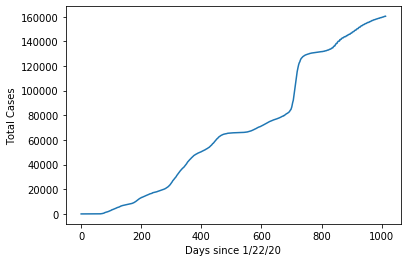

In [6]:
# Plot total cases over time from original table
plt.plot(range(len(cases_data)),cases_data)
plt.ylabel('Total Cases')
plt.xlabel("Days since 1/22/20")

Text(0.5, 0, 'Days since 1/22/20')

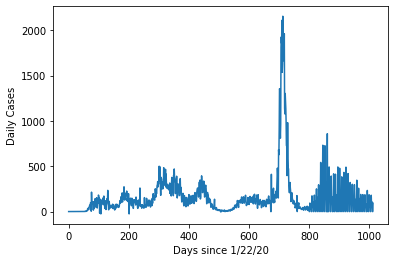

In [7]:
# Get the number of new daily cases
plt.plot(range(len(cases_data)-1),np.diff(cases_data))
plt.ylabel('Daily Cases')
plt.xlabel("Days since 1/22/20")

Text(0.5, 0, 'Days since 1/22/20')

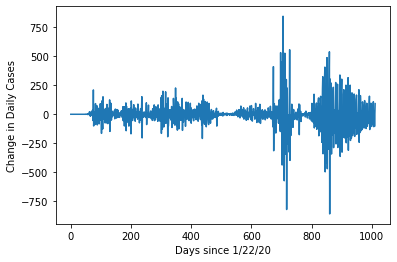

In [8]:
# Get the change in daily cases
plt.plot(range(len(cases_data)-2),np.diff(np.diff(cases_data)))
plt.ylabel('Change in Daily Cases')
plt.xlabel("Days since 1/22/20")

## Exploring the Mask Use By Conty Dataset

In [9]:
# load in mask compliance by county data
mask_compliance = pd.read_csv('./data/mask-use-by-county.csv')
mask_compliance.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


Text(0.5, 1.0, 'Histogram of Percentage of people stating thaty they always mask')

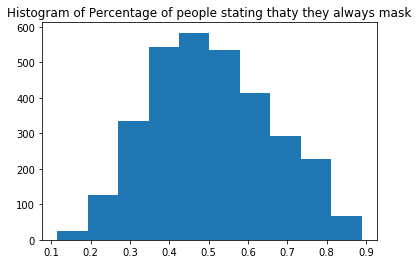

In [10]:
# Get distribution of high mask usage
plt.hist(mask_compliance['ALWAYS'])
plt.title("Histogram of Percentage of people stating thaty they always mask")

## Finding the FP for Baltimore
Using the us counties 2021 index found [here](https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-2021.csv) I searched and found the FP for Baltimore county

In [11]:
# Hardcoded variabel for Baltimore county
county_fp = 24005

In [12]:
# Get mask compliance row for baltimore county
baltimore_mack_compliance = mask_compliance[mask_compliance['COUNTYFP'] == county_fp]
baltimore_mack_compliance.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1195,24005,0.013,0.024,0.043,0.142,0.777


In [13]:
# What percentile is Baltimore county in alwsys adhering to 
# Masking policy

# Find the percentage using bisection search
percentile_array = []
# Iterate over each category
for c in baltimore_mack_compliance.columns[1:]:
    target = baltimore_mack_compliance[c].values[0]
    rng = (0,100)
    low = [rng[0], rng[1]/2]
    high = [rng[1]/2,rng[1]]
    for i in range(100):
        low_target = np.percentile(mask_compliance['ALWAYS'],(low[1]+low[0])/2)
        high_target = np.percentile(mask_compliance['ALWAYS'],(high[1]+high[0])/2)
        # If the value is in the left half of the bisection search
        if np.abs(target-low_target) <  np.abs(target-high_target):
            low = [low[0],(low[1]+low[0])/2]
            high = [(low[1]+low[0])/2,(low[1])]
        # Else its in the right half
        else:
            low = [high[0],(high[1]+high[0])/2]
            high = [(high[1]+high[0])/2,(high[1])]
    percentile_array.append((c,low[0]))
print(percentile_array)

[('NEVER', 4.3368086899380734e-17), ('RARELY', 1.0842021724853072e-16), ('SOMETIMES', 4.3368086899380734e-17), ('FREQUENTLY', 0.077056884765625), ('ALWAYS', 95.3125)]


From percentiles,, it seems that Baltimore county was very good at masking up as they are in the 95th percentile for counties masking and in the other categories that arent as complient they are in very small percentiles

## Exploring Mask Mandates By County

In [14]:
# Load in mask mandate data for all counties
mask_mandates = pd.read_csv('./data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mask_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [15]:
# Get the policies for baltimore county
baltimore_mask_mandates = mask_mandates[mask_mandates['County_Name'] == 'Baltimore County']
baltimore_mask_mandates.head(2)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
317903,MD,Baltimore County,24,5,4/10/2020,2,NaN,NaN,NaN,NaN
317904,MD,Baltimore County,24,5,4/11/2020,2,NaN,NaN,NaN,NaN


Here I remove the columns that dont contain any data with respect to masking policy. Even though we are supposed to begin the analysis on Febuary 1st 2020, it wouldnt make sense to only use the case data in an anslysis about the efficacy of masking policy. Therefore I will also cut the case data in order to match up with the masking policy data. Also I binarize the masking polic variable for easier use.

In [16]:
# Map values for fase mask requirements
baltimore_mask_mandates = baltimore_mask_mandates[baltimore_mask_mandates['Face_Masks_Required_in_Public'].notna()]
baltimore_mask_mandates['Masks_Required'] = baltimore_mask_mandates['Face_Masks_Required_in_Public'].map({"Yes":1, "No":0}).values
baltimore_mask_mandates.head(2)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Masks_Required
317911,MD,Baltimore County,24,5,4/18/2020,1,Yes,Official,https://governor.maryland.gov/wp-content/uploa...,"Md. Exec. Order No. 20-04-15-01 (Apr. 15, 2020)",1
317912,MD,Baltimore County,24,5,4/19/2020,1,Yes,Official,https://governor.maryland.gov/wp-content/uploa...,"Md. Exec. Order No. 20-04-15-01 (Apr. 15, 2020)",1


In [17]:
# Get all dates for mask mandates
baltimore_mask_mandates['date']

317911     4/18/2020
317912     4/19/2020
317913     4/20/2020
317914     4/21/2020
317915     4/22/2020
             ...    
1131836    8/11/2021
1131837    8/12/2021
1131838    8/13/2021
1131839    8/14/2021
1131840    8/15/2021
Name: date, Length: 485, dtype: object

In [18]:
# Get the law names for each of the new policies
baltimore_mask_mandates['Citation'].unique()

array(['Md. Exec. Order No. 20-04-15-01 (Apr. 15, 2020)',
       'Md. Exec. Order No. 20-07-29-01 (July 29, 2020)',
       'Md. Exec. Order No. 20-08-03-01 (Aug. 3, 2020)',
       'Md. Exec. Order No. 20-09-01-01 (Sept. 1, 2020)',
       'Md. Exec. Order No. 20-09-18-01 (Sept. 18, 2020)',
       'Md. Exec. Order No. 20-09-28-01 (Sept. 28, 2020)',
       'Md. Exec. Order No. 20-10-16-02 (Oct. 16, 2020)',
       'Md. Exec. Order No. 20-11-10-01 (Nov. 10 2020)',
       'Md. Exec. Order No. 20-11-17-01 (Nov. 17 2020)',
       'Md. Exec. Order No. 21-01-28-01 (Jan. 28, 2021)',
       'Md. Exec. Order No. 21-02-23-01 (Feb. 23, 2021)',
       'Md. Exec. Order No. 21-03-09-01 (Mar. 9, 2021)',
       'Md. Exec. Order No. 21-04-21-01 (Apr. 21, 2021)',
       'Md. Exec. Order No. 21-04-28-01 (Apr. 28, 2021)',
       'Md. Exec. Order No. 21-05-14-01 (May 14, 2021)'], dtype=object)

## Looking into the policies that are enacted
There are 15 different policy statments made and each of them may be different
Here are the links to all 15
- [Md. Exec. Order No. 20-04-15-01 (Apr. 15, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/04/Masks-and-Physical-Distancing-4.15.20.pdf)
- [Md. Exec. Order No. 20-07-29-01 (July 29, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/07/Gatherings-10th-AMENDED-7.29.20.pdf)
- [Md. Exec. Order No. 20-08-03-01 (Aug. 3, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/08/2020-08-03-11-08.pdf)
- [Md. Exec. Order No. 20-09-01-01 (Sept. 1, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/09/Gatherings-12th-AMENDED-9.1.20.pdf)
- [Md. Exec. Order No. 20-09-18-01 (Sept. 18, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/09/Gatherings-13th-AMENDED-9.18.20.pdf)
- [Md. Exec. Order No. 20-09-28-01 (Sept. 28, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/09/Gatherings-14th-AMENDED-9.28.20.pdf)
- [Md. Exec. Order No. 20-10-16-02 (Oct. 16, 2020)](https://governor.maryland.gov/wp-content/uploads/2020/10/Gatherings-15th-AMENDED-10.16.20.pdf)
- [Md. Exec. Order No. 20-11-10-01 (Nov. 10 2020)](https://governor.maryland.gov/wp-content/uploads/2020/11/EO-11.10.20.pdf)
- [Md. Exec. Order No. 20-11-17-01 (Nov. 17 2020)](https://governor.maryland.gov/wp-content/uploads/2020/11/Order-20-11-17-01.pdf)
- [Md. Exec. Order No. 21-01-28-01 (Jan. 28, 2021)](https://governor.maryland.gov/wp-content/uploads/2021/01/Gatherings-18th-AMENDED-01.28.21.pdf)
- [Md. Exec. Order No. 21-02-23-01 (Feb. 23, 2021)](https://governor.maryland.gov/wp-content/uploads/2021/03/Gatherings-19th-AMENDED-02.23.21.pdf)
- [Md. Exec. Order No. 21-03-09-01 (Mar. 9, 2021)](https://governor.maryland.gov/wp-content/uploads/2021/03/Gatherings-20th-AMENDED-3.9.21.pdf)
- [Md. Exec. Order No. 21-04-21-01 (Apr. 21, 2021)](https://governor.maryland.gov/wp-content/uploads/2021/04/Gatherings-22d-AMENDED-4.28.21.pdf)
- Md. Exec. Order No. 21-04-28-01 (Apr. 28, 2021) - cannot find
- [Md. Exec. Order No. 21-05-14-01 (May 14, 2021)](https://governor.maryland.gov/wp-content/uploads/2021/05/Gatherings-24th-AMENDED-5.14.21.pdf)

## Categorizing Masking Policy Stringency
- (Apr. 15, 2020)
    - no large gatherings
    - physical distance for retail establishments
    - face coverings
- (July 29, 2020)
    - no large gatherings
    - social distincing
    - face coverings
    - places required to close
- (Aug. 3, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Sept. 1, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Sept. 18, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Sept. 28, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Oct. 16, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Nov. 10 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Nov. 17 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Jan. 28, 2020)
    - no large gatherings
    - social distancing
    - face coverings
    - places required to close
- (Feb. 23, 2021)
    - no large gatherings
    - social distancing
    - face coverings
- (Mar. 9, 2021)
    - face coverings
- (Apr. 21, 2021)
    - face coverings
- (Apr. 28, 2021) - cannot find
- (May 14, 2021)
    - Basically no mask mandate
Going to assume that the policy from April 21st was the same as the previous

The mapping is as follows
- 0: Basically no mandate
- 1: Face coverings required
- 2: No large Gatherings, face coverings required, and social distincing
- 3: No large Gatherings, places required to close down, face coverings required, and social distincing

In [19]:
## Mapping policys to values
baltimore_mask_mandates['Citation_Mapped'] = baltimore_mask_mandates['Citation'].map(
    {
       'Md. Exec. Order No. 20-04-15-01 (Apr. 15, 2020)' : 2,
       'Md. Exec. Order No. 20-07-29-01 (July 29, 2020)' : 3,
       'Md. Exec. Order No. 20-08-03-01 (Aug. 3, 2020)' :3,
       'Md. Exec. Order No. 20-09-01-01 (Sept. 1, 2020)':3,
       'Md. Exec. Order No. 20-09-18-01 (Sept. 18, 2020)':3,
       'Md. Exec. Order No. 20-09-28-01 (Sept. 28, 2020)':3,
       'Md. Exec. Order No. 20-10-16-02 (Oct. 16, 2020)':3,
       'Md. Exec. Order No. 20-11-10-01 (Nov. 10 2020)':3,
       'Md. Exec. Order No. 20-11-17-01 (Nov. 17 2020)':3,
       'Md. Exec. Order No. 21-01-28-01 (Jan. 28, 2021)':3,
       'Md. Exec. Order No. 21-02-23-01 (Feb. 23, 2021)':2,
       'Md. Exec. Order No. 21-03-09-01 (Mar. 9, 2021)': 1,
       'Md. Exec. Order No. 21-04-21-01 (Apr. 21, 2021)':1,
       'Md. Exec. Order No. 21-04-28-01 (Apr. 28, 2021)':1,
       'Md. Exec. Order No. 21-05-14-01 (May 14, 2021)':0 
    }
)

## Exploring the relationship between mandate stringency and daily cases

In [20]:
baltimore_mask_mandates[['date','Citation_Mapped']]

,date,Citation_Mapped
317911,4/18/2020,2
317912,4/19/2020,2
317913,4/20/2020,2
317914,4/21/2020,2
317915,4/22/2020,2
...,...,...
1131836,8/11/2021,0
1131837,8/12/2021,0
1131838,8/13/2021,0
1131839,8/14/2021,0


In [21]:
# Clip the cases so that timelines of mandate data match up with case data
# Also move back the dates 5 days as that is the average time it takes for someone
# To become symptomatic, and therefore have suspicion enough to take a test for covid 
clipped_case_data = baltimore_data[baltimore_data.columns[93:578]].values[0]

In [22]:
# Create dataframe so you can use Seaborn plots
daily_vs_stringency = pd.DataFrame(data=np.array([baltimore_mask_mandates['Citation_Mapped'].values[1:],np.diff(clipped_case_data)]).T,columns=["Stringency", "Cases"])

This plot shows the relationship between mandate stringency and the daily number of cases. Higher numbers for stringency indicate more strict COVID policies. Now obviously this is an oversimplified model of stringency as there are many other factors that go into it that will have downstream impacts on daily cases than what were accounted for.

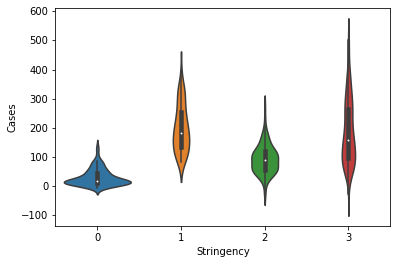

In [23]:
# Plot the distributions of stringency vs cases
sns.violinplot(data=daily_vs_stringency,x='Stringency',y='Cases')

In [24]:
# Find the variance of each stringency class
daily_vs_stringency.groupby('Stringency').var()

,Cases
Stringency,
0,801.666433
1,6250.154229
2,2428.766578
3,12087.411894


In [25]:
# Find the mean of each stringency class
daily_vs_stringency.groupby('Stringency').mean()

,Cases
Stringency,
0,30.913978
1,199.238806
2,93.692308
3,187.729469


Since the magnitide of change will be smaller in the earlier stages we instead want to look a the percentage changes from day to day to see if mandates have an impact on that

In [26]:
# Do the same for percent daily change and stringency levels
daily_percent_vs_stringency = pd.DataFrame(data=np.array([baltimore_mask_mandates['Citation_Mapped'].values[1:],100*np.diff(clipped_case_data)/clipped_case_data[1:]]).T,columns=["Stringency", "Cases"])

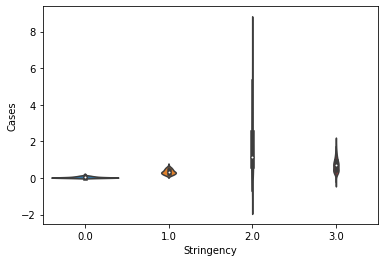

In [27]:
# Plot distributions
sns.violinplot(data=daily_percent_vs_stringency,x='Stringency',y='Cases')

This plot of the percentage change in daily rates shows interesting patterns similiar to a dampening harmonic oscilator. There could be some variable accountable for both the upticks and the decreases in these numbers related to masking policy

Text(0, 0.5, 'Percentage change in Daily cases')

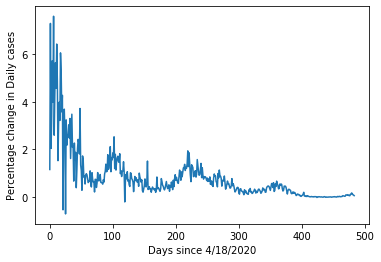

In [28]:
# Plot time series of daily percentage change in cases
plt.plot(100*np.diff(clipped_case_data)/clipped_case_data[1:])
plt.xlabel("Days since 4/18/2020")
plt.ylabel("Percentage change in Daily cases")

In [29]:
# Do for just daily change not percentage change
daily_vs_stringency = pd.DataFrame(data=np.array([baltimore_mask_mandates['Citation_Mapped'].values[2:],np.diff(np.diff(clipped_case_data))]).T,columns=["Stringency", "Cases"])

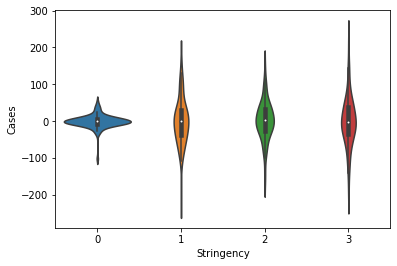

In [30]:
# Plot stringency vs daily cases distributions 
sns.violinplot(data=daily_vs_stringency,x='Stringency',y='Cases')

## Identify Changepoints And See If They Line Up With Any Policy Changes

In [31]:
# Use RBF kernel for the Pelt changepoint algorithm
model = "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(100*np.diff(clipped_case_data)/clipped_case_data[1:])

In [32]:
# Get the locations in the array when policies are first enacted or changed
policy_change_timepoints = []
prev = None
for i,c in enumerate(baltimore_mask_mandates['Citation']):
    if c != prev:
        policy_change_timepoints.append(i)
    prev = c
policy_change_timepoints

[0, 104, 107, 139, 156, 163, 181, 207, 216, 285, 311, 325, 368, 375, 392]

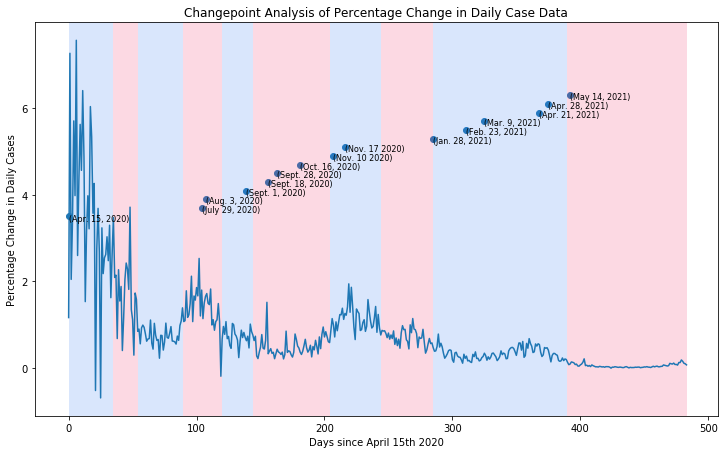

In [33]:
# Plot changepoints
my_bkps = algo.predict(pen=3)
# show results
fig, ax_arr = rpt.display(100*np.diff(clipped_case_data)/clipped_case_data[1:], my_bkps, figsize=(10, 6))

# Stagger policy points
ax_arr[0].scatter(policy_change_timepoints,[3.5+(i*.2) for i in range(len(policy_change_timepoints))])

labels = [s.replace('Md. Exec. Order No. ', '')[12:] for s in baltimore_mask_mandates['Citation'].values[policy_change_timepoints]]

# Annotate the scatter plot with dates of policies
for i in range(len(policy_change_timepoints)):
    ax_arr[0].annotate(labels[i], (policy_change_timepoints[i], 3.4+(i*.2)),fontsize=8)
plt.xlabel("Days since April 15th 2020")
plt.ylabel("Percentage Change in Daily Cases")
plt.title("Changepoint Analysis of Percentage Change in Daily Case Data")
plt.show()

In [34]:
# Function to get the moving average of a time series array
def moving_average(a, n=7) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
# Calcualte average with the last 7 days
n=7
# Get percentage change in cases and calcualte moving average 
moved_avarage = moving_average(100*np.diff(clipped_case_data)/clipped_case_data[1:],n=n)

coeffs = []
p_change = policy_change_timepoints
p_change.append(moved_avarage.shape[0])
# For each time period that the policy is active
for i in range(len(p_change)-1):
    # Ger the smoothed range where its active
    smoothed_range = moved_avarage[p_change[i]:p_change[i+1]]
    # Calculate a linear regression over the range
    lin = LinearRegression().fit(np.array(range(0,p_change[i+1]-p_change[i])).reshape(-1,1),smoothed_range)
    # Add the coefficent to the array
    coeffs.append(lin.coef_[0])

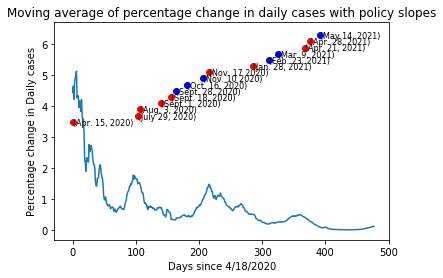

In [35]:
# Plot the moving average of percentage change in daily cases
plt.plot(moved_avarage)
plt.xlabel("Days since 4/18/2020")
plt.ylabel("Percentage change in Daily cases")
plt.title("Moving average of percentage change in daily cases with policy slopes")
# Iterate over each policy
for i,p in enumerate(p_change[:-1]):
    # If the slope is negative color red
    if coeffs[i] < 0:
        plt.scatter(p,3.5+(i*.2 ),c='red')
    # Else color blue 
    else:
        plt.scatter(p,3.5+(i*.2 ),c='blue')
# Labels for each policy date
labels = [s.replace('Md. Exec. Order No. ', '')[12:] for s in baltimore_mask_mandates['Citation'].values[policy_change_timepoints]]

# Plot policies
for i in range(len(policy_change_timepoints)-1):
    plt.annotate(labels[i], (policy_change_timepoints[i], 3.4+(i*.2)),fontsize=8)

Text(0, 0.5, 'Slope of Percentage Change in Covid Cases')

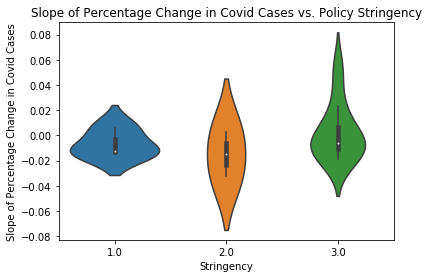

In [36]:
# Hardcocded array of policy severity ratings
severities = [ 2,3,3,3,3,3,3,3,3,3,2,1,1,1]
# Create dataframe for seaborn
coeffs_vs_stringency = pd.DataFrame(data=np.array([severities,coeffs[:-1]]).T,columns=["Stringency", "Coefficents"])
# Plot coefficents vs Stringency
sns.violinplot(data=coeffs_vs_stringency,x='Stringency',y='Coefficents')
plt.title("Slope of Percentage Change in Covid Cases vs. Policy Stringency")
plt.ylabel('Slope of Percentage Change in Covid Cases')

## Further Investigation 
Based on the above graph there are a few interesting policy changes that lie before change points.
- Apr 15 2020
    - First legal mask mandate order
- July 29 2020 & Aug 3 2020 (because they lie at an inflection point)
    - Before only take out food, now people can eat outside and inside so long as there is less than 50% capacity
    - Theaters closed down
    - Gambling establishments allowed to open up
- Sept 18 2020
    - Establishments capacity increased to 75% from 50
    - Theaters allowed to open
- Nov 17  2020 (Because of inflection point proximity)
    - They had increased the occupancy limit of establishments in teh order before, however in this order they reduced it back to 50%
    - Reclosure of senior centers
    - Government gatherings limited
- April 28 2021
    - The one that I couldnt find the executive order for

These policy changes seem to have less to do with masking policy and more with the stringency of large gatherings. 

## Part 2 Extension
Here we will analyze police call records for high priority calls as a gague for the prevalence of crime in the county. We will try to see if the severity of covid impacted the number of crimes happening on a day to day basis.

- [2020 Police Department Calls](https://data.baltimorecity.gov/datasets/911-calls-for-service-2020/explore)
- [2021 Police Department Calls](https://data.baltimorecity.gov/datasets/911-calls-for-service-2021/explore)

In [37]:
# Dateframe for all Baltimore PD calls for 2020
police_calls_2020_df = pd.read_csv('./data/911_Calls_For_Service_2020.csv')
police_calls_2020_df.head()

,objectid,recordid,callkey,calldatetime,priority,district,description,callnumber,incidentlocation,location,neighborhood,policedistrict,policepost,councildistrict,sheriffdistricts,community_statistical_areas,census_tracts,vrizones,zipcode
0,1,8285810,10CC9DA95F732422,2020/09/29 08:10:00+00,Low,ND,HIT AND RUN,P202730971,1200 W NORTHERN PY,1200 W NORTHERN PY BALTIMORE MD,Sabina-Mattfeldt,Northern,533.0,5.0,D2,Mount Washington/Coldspring,Census Tract 2715.01,NaN,21209.0
1,2,8286114,10CC9DA95F7333B2,2020/09/29 09:16:00+00,Low,SD,LARCENY,P202731136,900 WASHINGTON BL,900 WASHINGTON BL BALTIMORE MD,Washington Village/Pigtown,Southern,932.0,10.0,D7,Washington Village/Pigtown,Census Tract 2101,NaN,21230.0
2,3,8286082,10CC9DA95F733855,2020/09/29 09:36:00+00,Low,NE,AUTO THEFT,P202731188,4200 BLK FENWICK AV,4200 BLK FENWICK AV BALTIMORE MD,Hillen,Northeastern,412.0,3.0,D4,Northwood,Census Tract 2709.03,NaN,21218.0
3,4,8290068,10CC9DA95F748561,2020/09/30 09:17:00+00,Low,SE,OTHER,P202741169,1100 S CONKLING ST,1100 S CONKLING ST BALTIMORE MD,Canton,Southeastern,232.0,1.0,D6,Highlandtown,Census Tract 2609,NaN,21224.0
4,5,8290067,10CC9DA95F748784,2020/09/30 09:26:00+00,Low,WD,OTHER,P202741196,2400 WINCHESTER ST,2400 WINCHESTER ST BALTIMORE MD,Bridgeview/Greenlawn,Western,723.0,9.0,D9,Greater Rosemont,Census Tract 1605,NaN,21216.0


In [38]:
# Isolate the date variable 
police_calls_2020_df['call_date'] = police_calls_2020_df['calldatetime'].apply(lambda x: x[:10])

In [39]:
# Filter for high priority calls
high_prio_2020 = police_calls_2020_df[police_calls_2020_df['priority']=='High']

In [40]:
# Get date for 2021 into dataframe
police_calls_2021_df = pd.read_csv('./data/911_Calls_For_Service_2021.csv')
police_calls_2021_df.head()

,OBJECTID,callKey,callDateTime,priority,district,description,callNumber,incidentLocation,location,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,ZIPCode,NeedsSync,IsDeleted
0,1,6301020A5FEEAC59,2021/01/01 05:00:00+00,High,WD,DISCHRG FIREARM,P210010012,2100 BLK EDMONDSON AV,2100 BLK EDMONDSON AV BALTIMORE MD,Midtown-Edmondson,Western,722.0,9.0,D8,Sandtown-Winchester/Harlem Park,Census Tract 1604,NaN,21223.0,True,False
1,2,29CC9DA95FEEAC72,2021/01/01 05:00:00+00,Non-Emergency,WD,SUPV COMPLAINT,P210010019,1300 HARLEM AV,1300 HARLEM AV BALTIMORE MD,Harlem Park,Western,713.0,9.0,D8,Sandtown-Winchester/Harlem Park,Census Tract 1602,Central,21217.0,False,False
2,3,5601020A5FEEAC7C,2021/01/01 05:00:00+00,Low,NE,911/NO VOICE,P210010011,1900 E BELVEDERE AV,1900 E BELVEDERE AV BALTIMORE MD,Loch Raven,Northeastern,415.0,4.0,D3,Loch Raven,Census Tract 2708.03,NaN,21239.0,True,False
3,4,9C01020A5FEEAC67,2021/01/01 05:00:00+00,High,ND,ShotSpot Alert,P210010002,200 W NORTH AV,200 W NORTH AV BALTIMORE MD,Charles North,Central,141.0,12.0,D8,Midtown,Census Tract 1205,NaN,21201.0,True,False
4,5,5901020A5FEEAC81,2021/01/01 05:00:00+00,Low,NE,911/NO VOICE,P210010008,1100 E COLD SPRING LN,1100 E COLD SPRING LN BALTIMORE MD,New Northwood,Northeastern,413.0,4.0,D2,Northwood,Census Tract 2709.01,NaN,21239.0,True,False


In [41]:
# Make new column for call date
police_calls_2021_df['call_date'] = police_calls_2021_df['callDateTime'].apply(lambda x: x[:10])

In [42]:
# Filter for high priority calls
high_prio_2021 = police_calls_2021_df[police_calls_2021_df['priority']=='High']
# Turn columns ot lower case like 2020 table
high_prio_2021.columns = [c.lower() for c in high_prio_2021.columns]

In [43]:
# Full table for high priority calls from 2020-2021
high_priority_calls = pd.concat([high_prio_2020,high_prio_2021])

In [44]:
high_priority_calls.head()

,objectid,recordid,callkey,calldatetime,priority,district,description,callnumber,incidentlocation,location,...,policepost,councildistrict,sheriffdistricts,community_statistical_areas,census_tracts,vrizones,zipcode,call_date,needssync,isdeleted
322,323,8312570.0,11CC9DA95F7B8D64,2020/10/05 17:17:00+00,High,NW,BURGLARY,P202793260,4000 OAKFORD AV,4000 OAKFORD AV BALTIMORE MD,...,621.0,6.0,D1,Dorchester/Ashburton,Census Tract 1510,NaN,21215.0,2020/10/05,NaN,NaN
360,361,8334533.0,11CC9DA95F8248C1,2020/10/10 19:50:00+00,High,ND,COMMON ASSAULT,P202843673,2400 LIBERTY HEIGHTS AV,2400 LIBERTY HEIGHTS AV BALTIMORE MD,...,611.0,7.0,D1,Greater Mondawmin,Census Tract 1505,NaN,21215.0,2020/10/10,NaN,NaN
418,419,8396849.0,11CC9DA95F94B30F,2020/10/24 19:04:00+00,High,NE,COMMON ASSAULT,P202983671,LONGVIEW AV/ELMORA AV,LONGVIEW AV and ELMORA AV BALTIMORE MD,...,434.0,13.0,D5,Belair-Edison,Census Tract 801.02,NaN,21213.0,2020/10/24,NaN,NaN
479,480,8458028.0,11CC9DA95FA73F26,2020/11/07 19:43:00+00,High,CD,DISCHRG FIREARM,P203123718,W NORTH AV/EUTAW PL,W NORTH AV and EUTAW PL BALTIMORE MD,...,132.0,11.0,D8,Upton/Druid Heights,Census Tract 1403,NaN,21217.0,2020/11/07,NaN,NaN
508,509,8487275.0,11CC9DA95FB0262F,2020/11/14 13:47:00+00,High,ED,BURGLARY,P203192410,600 GUTMAN AV,600 GUTMAN AV BALTIMORE MD,...,342.0,12.0,D5,Midway/Coldstream,Census Tract 908,NaN,21218.0,2020/11/14,NaN,NaN


In [45]:
# List all call reasons
high_priority_calls['description'].unique()

array(['BURGLARY', 'COMMON ASSAULT', 'DISCHRG FIREARM', 'AGGRAV ASSAULT',
       'HARRASSMENT', 'THREAT', 'NONBREATHING / A', 'AUTO ACC/INJURY',
       'ShotSpot Alert', 'FIRE', 'SHOOTING', 'CAR JACKING',
       'DEPTACCIDENT/INJ', 'ROBBERY ARMED', 'OVERDOSE', 'ARMED PERSON',
       'HOUSE ON FIRE', 'ROBBERY UNARMED', 'VEH VS POLE', 'VEH ACCIDENT',
       'DISORDERLY', 'AUTO ACCIDENT', 'CUTTING', 'POSS',
       'ABDUCTION OTHER', 'BY THREAT', 'BANK HOLDUP', 'BEHAVIOR CRISIS',
       'WANTED ON WARR', 'OTHER', 'EP  PAPERS', 'RECOVERED VEH',
       'PICKUP ORDERS', 'DOG BITE', 'FORCED ENTRY', 'POSSIBLE',
       'HOLDUP ALARM', 'EXPLOSION', 'ATTEMPTED', 'INVESTIGATE',
       'CHECK WELLBEING', 'ATTEMPT', 'POSS ARMED PERS', 'DOA', ']',
       'THREATS', 'LYING IN STREET', 'ARMEDCAR JACKING', 'WALK IN',
       'BY POINTING', 'WATER RESCUE', 'BAILOUT', 'AUTO ACC/DEATH',
       'FLOODING', 'WALK IN VICTIM', 'ASSIST MTA', 'CHK WELLBEING',
       'ABDUCT/PARENT', 'POSS ARMED PERSO', 'BURGLARYP'

In [46]:
# Get daily counts
call_counts = high_priority_calls.groupby(by='call_date')['callkey'].count()

In [47]:
# Line calls up with covid case data
clipped_call_counts = call_counts[105:-138].values

Text(0, 0.5, 'Percentage change in cases per day')

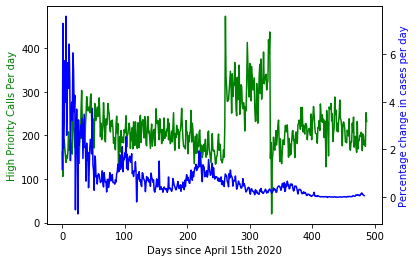

In [48]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot call counts
x1 = range(len(clipped_call_counts))
# Plot The percentage change in case data
x2 = range(len(100*np.diff(clipped_case_data)/clipped_case_data[1:]))

# Label axis
ax1.plot(x1, clipped_call_counts, 'g-')
ax2.plot(x2, 100*np.diff(clipped_case_data)/clipped_case_data[1:], 'b-')
ax1.set_xlabel('Days since April 15th 2020')
ax1.set_ylabel('High Priority Calls Per day', color='g')
ax2.set_ylabel('Percentage change in cases per day', color='b')

In [49]:
high_priority_calls.head()

,objectid,recordid,callkey,calldatetime,priority,district,description,callnumber,incidentlocation,location,...,policepost,councildistrict,sheriffdistricts,community_statistical_areas,census_tracts,vrizones,zipcode,call_date,needssync,isdeleted
322,323,8312570.0,11CC9DA95F7B8D64,2020/10/05 17:17:00+00,High,NW,BURGLARY,P202793260,4000 OAKFORD AV,4000 OAKFORD AV BALTIMORE MD,...,621.0,6.0,D1,Dorchester/Ashburton,Census Tract 1510,NaN,21215.0,2020/10/05,NaN,NaN
360,361,8334533.0,11CC9DA95F8248C1,2020/10/10 19:50:00+00,High,ND,COMMON ASSAULT,P202843673,2400 LIBERTY HEIGHTS AV,2400 LIBERTY HEIGHTS AV BALTIMORE MD,...,611.0,7.0,D1,Greater Mondawmin,Census Tract 1505,NaN,21215.0,2020/10/10,NaN,NaN
418,419,8396849.0,11CC9DA95F94B30F,2020/10/24 19:04:00+00,High,NE,COMMON ASSAULT,P202983671,LONGVIEW AV/ELMORA AV,LONGVIEW AV and ELMORA AV BALTIMORE MD,...,434.0,13.0,D5,Belair-Edison,Census Tract 801.02,NaN,21213.0,2020/10/24,NaN,NaN
479,480,8458028.0,11CC9DA95FA73F26,2020/11/07 19:43:00+00,High,CD,DISCHRG FIREARM,P203123718,W NORTH AV/EUTAW PL,W NORTH AV and EUTAW PL BALTIMORE MD,...,132.0,11.0,D8,Upton/Druid Heights,Census Tract 1403,NaN,21217.0,2020/11/07,NaN,NaN
508,509,8487275.0,11CC9DA95FB0262F,2020/11/14 13:47:00+00,High,ED,BURGLARY,P203192410,600 GUTMAN AV,600 GUTMAN AV BALTIMORE MD,...,342.0,12.0,D5,Midway/Coldstream,Census Tract 908,NaN,21218.0,2020/11/14,NaN,NaN


In [50]:
# Group calls by date and reason for call
test = high_priority_calls.groupby(['call_date','description'],as_index=False).count()
test.head()

,call_date,description,objectid,recordid,callkey,calldatetime,priority,district,callnumber,incidentlocation,...,policedistrict,policepost,councildistrict,sheriffdistricts,community_statistical_areas,census_tracts,vrizones,zipcode,needssync,isdeleted
0,2020/01/01,ABDUCT/PARENT,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,0
1,2020/01/01,ABDUCTION OTHER,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,0
2,2020/01/01,AGGRAV ASSAULT,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,2,15,0,0
3,2020/01/01,ARMED PERSON,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,4,23,0,0
4,2020/01/01,AUTO ACC/INJURY,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,0,22,0,0


In [51]:
test['description'].unique()

array(['ABDUCT/PARENT', 'ABDUCTION OTHER', 'AGGRAV ASSAULT',
       'ARMED PERSON', 'AUTO ACC/INJURY', 'BURGLARY', 'BY THREAT',
       'COMMON ASSAULT', 'CUTTING', 'DISCHRG FIREARM', 'FIRE',
       'HOLDUP ALARM', 'NONBREATHING / A', 'OVERDOSE', 'POSSIBLE',
       'RECOVER PROPERTY', 'ROBBERY ARMED', 'ROBBERY UNARMED', 'SHOOTING',
       'ShotSpot Alert', 'CAR JACKING', 'DEPTACCIDENT/INJ', 'ATTEMPT',
       'CK WELL BEING', 'WATER RESCUE', 'AUDIBLE ALARM', 'OTHER',
       'POSS ARMD PERSON', 'POSS BURGLARY', 'LOST CHILD', 'POSS BREAK IN',
       'THREAT', 'ASSIST MTA', 'ATTEMPTED', 'POSS DOA', 'POSS ARMED PERS',
       'BANK HOLDUP', 'DISORDERLY', 'EXPLOSION', 'WALK IN  PATIENT',
       'DOG BITE', 'INVESTIGATE', 'FAMILY DISTURB', 'THREATS',
       'POLICE INFO', 'AUTO ACCIDENT', 'SUSPICIOUS PERS', 'VEHICLE FIRE',
       'CHILD IN CAR', 'BEHAVIOR CRISIS', 'HARRASSMENT', 'MISSING PERSON',
       'ATT RBBRY UNRMD', 'HELICOPTER', 'PLANE CRASH', 'POSS BROKEN MAIN',
       'AUTO ACC/DEATH',

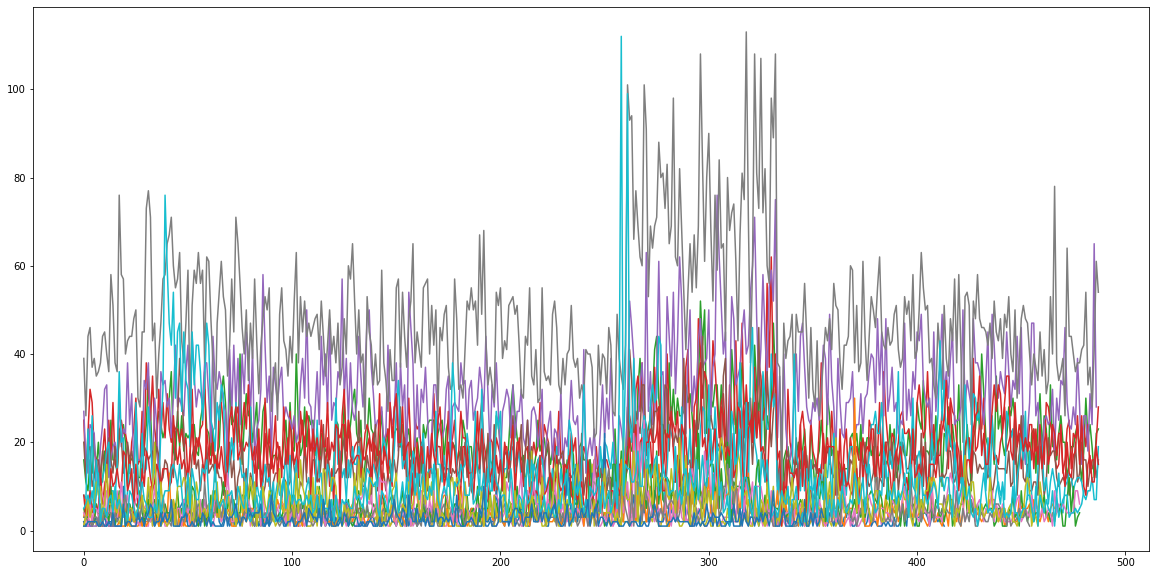

In [52]:
# Plot all of the aggregated by reason over time to see which ones 
# Are responsible for the weird increase
plt.rcParams["figure.figsize"] = (20,10)
nums= []
for p in test['description'].unique():
    v = test[test['description'] == p]['calldatetime'].values[105:-138]
    nums.append(v)
    plt.plot(v)

In [53]:
# Get the max of eaxh timme series
maxes = [n.max() if len(n) > 0 else 0 for n in nums]

In [54]:
# Pair the max with the description of the call
maxes_w_d = [(m,d) for m,d in zip(maxes,test['description'].unique())]

In [55]:
# Sort to top 5 highest call reasons 
sorted(maxes_w_d,key=lambda x:x[0],reverse=True)[:5]

[(113, 'COMMON ASSAULT'),
 (112, 'ShotSpot Alert'),
 (99, 'DISCHRG FIREARM'),
 (76, 'AUTO ACC/INJURY'),
 (62, 'ARMED PERSON')]

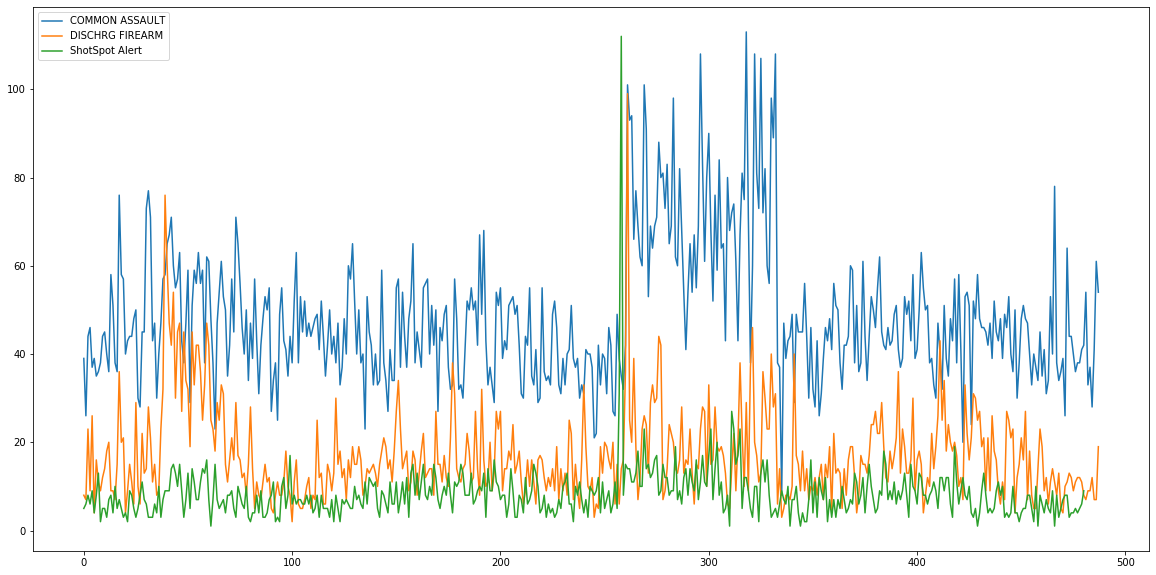

In [56]:
# Plot just the time series for Assault, Shot spot alert, and discharging firearms
plt.rcParams["figure.figsize"] = (20,10)
selected_nums= []
for p in test['description'].unique():
    if p in ['COMMON ASSAULT','ShotSpot Alert','DISCHRG FIREARM']:
        v = test[test['description'] == p]['calldatetime'].values[105:-138]
        selected_nums.append(v)
        plt.plot(v,label=p)
        
leg = plt.legend(loc='upper left')
plt.show()

### Use Cross Convergent Mapping for Causality Analysis

Here we will attempt to see if there is a causal relationship between the high priority calls and the percentage change in covid cases. To do this we will use Cross convergent mapping and the CCM package to run the analysis

In [57]:
# The variable to be predicted is the call counts, with the x variable as percentage change in cases
Y = clipped_call_counts[:-4]
X = 100*np.diff(clipped_case_data)/clipped_case_data[1:]

In [58]:
# Print out shapes to make sure they line up
X.shape,Y.shape

((484,), (484,))

Iterate over embedding dimensions to see which one is best

In [59]:
#split the embedded time series
best = 0
# Iterate over lag and embedding values and run the analysis
for l in range(1,15):
    for e in range(1,10):
        lag = l
        embed = e
        e1 = ccm.Embed(X)
        e2 = ccm.Embed(Y)
        X_embedded = e1.embed_vectors_1d(lag,embed)
        Y_embedded = e2.embed_vectors_1d(lag,embed)

        x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X_embedded,Y_embedded, percent=.8)

        CCM = ccm.CCM() #initiate the class

        #library lengths to test
        len_tr = len(x1tr)
        lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

        #test causation
        CCM.fit(x1tr,x2tr)
        x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

        sc1,sc2 = CCM.score()
        m,b = np.linalg.lstsq(np.vstack((np.array(sc1),np.ones(len(sc1)))).T, np.array(range(len(sc1))), rcond=None)[0]
        # pick the time series that has the best increasing slope
        if m > best:
            print(l,e)
            best = m

6 2
7 2
11 8


In [60]:
# Use the best selected lag values from the previous step
lag = 11
embed = 8
e1 = ccm.Embed(X)
e2 = ccm.Embed(Y)
X_embedded = e1.embed_vectors_1d(lag,embed)
Y_embedded = e2.embed_vectors_1d(lag,embed)

x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X_embedded,Y_embedded, percent=.8)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

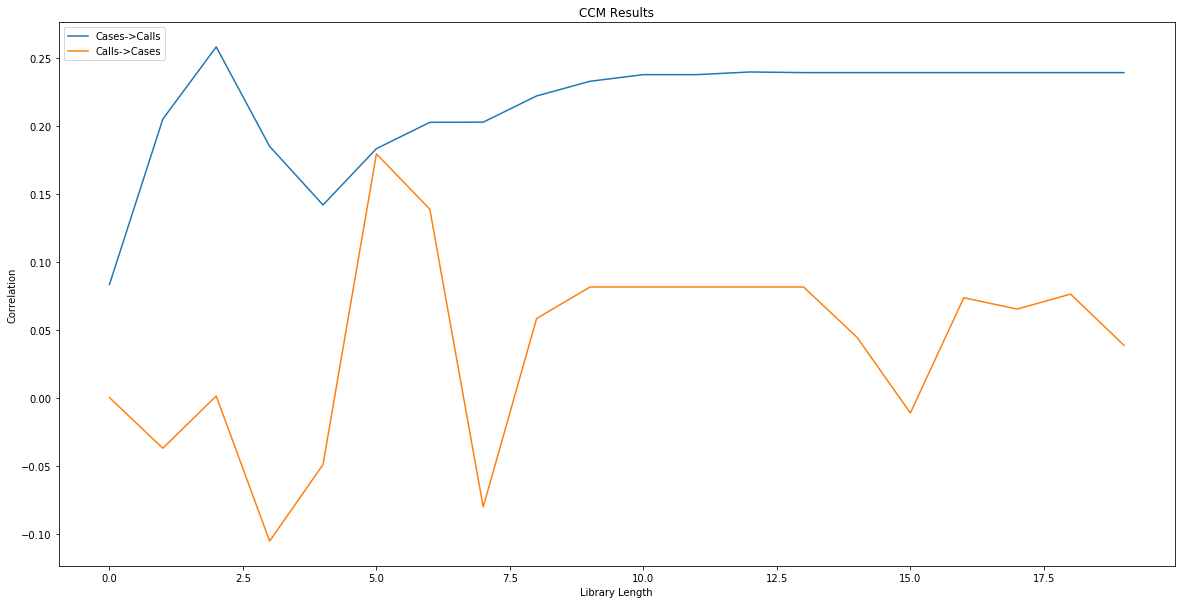

In [61]:
# Plot the Correlation of the predictions based off of the library length 
plt.plot(sc1,label='Cases->Calls')
plt.plot(sc2,label='Calls->Cases')
plt.xlabel("Library Length")
plt.ylabel("Correlation")
plt.title("CCM Results")
plt.legend(loc='upper left')

No causal relationshup found between all calls and covid severity

Perform the same analysis for discharged firearms

In [62]:
# Change the variable to just discharged firearms
discharged_firearm_calls = test[test['description'] == 'DISCHRG FIREARM']['calldatetime'].values[105:-142]
Y = discharged_firearm_calls

In [63]:
#split the embedded time series
best = 0
# Iterate over lag and embedding values and run the analysis
for l in range(1,15):
    for e in range(1,10):
        lag = l
        embed = e
        e1 = ccm.Embed(X)
        e2 = ccm.Embed(Y)
        X_embedded = e1.embed_vectors_1d(lag,embed)
        Y_embedded = e2.embed_vectors_1d(lag,embed)

        x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X_embedded,Y_embedded, percent=.75)

        CCM = ccm.CCM() #initiate the class

        #library lengths to test
        len_tr = len(x1tr)
        lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

        #test causation
        CCM.fit(x1tr,x2tr)
        x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

        sc1,sc2 = CCM.score()
        m,b = np.linalg.lstsq(np.vstack((np.array(sc1),np.ones(len(sc1)))).T, np.array(range(len(sc1))), rcond=None)[0]
        # pick the time series that has the best increasing slope
        if m> best:
            print(l,e)
            best = m

1 1
1 7
1 8
11 7
12 8
14 8


In [64]:
# Use the best selected lag values from the previous step
lag = 14
embed = 8
e1 = ccm.Embed(X)
e2 = ccm.Embed(Y)
X_embedded = e1.embed_vectors_1d(lag,embed)
Y_embedded = e2.embed_vectors_1d(lag,embed)

x1tr, x1te, x2tr, x2te = ccm.utilities.train_test_split(X_embedded,Y_embedded, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

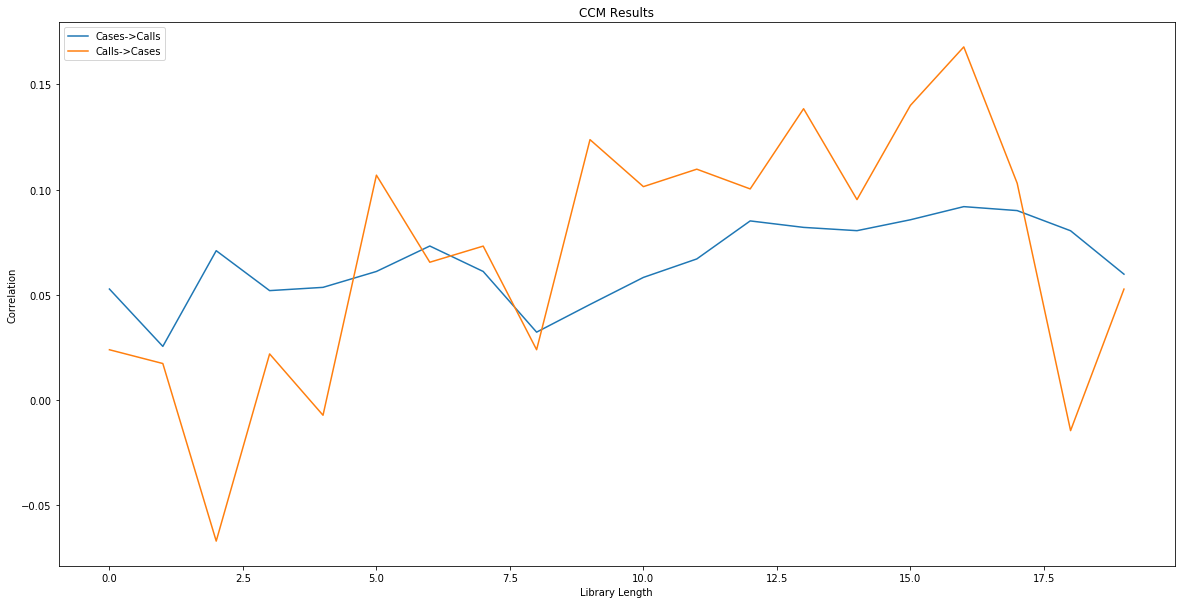

In [65]:
# Plot the Correlation of the predictions based off of the library length 
plt.plot(sc1,label='Cases->Calls')
plt.plot(sc2,label='Calls->Cases')
plt.xlabel("Library Length")
plt.ylabel("Correlation")
plt.title("CCM Results")
plt.legend(loc='upper left')

This also shows that there is no or minimal causal relationship between percentage change in daily cases and calls for firearms.